In [436]:
import json
import re
from bert_score import score
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

In [488]:
associations_valid = [('data/test_data/few_shot/test_data_2024_abstract_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_abstract_prompts_fewshot_gpt4o_results.jsonl', 'GPT4o-Abstract-Fewshot'),
                      ('data/test_data/few_shot/test_data_2024_abstract_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_abstract_prompts_oneshot_gpt4o_results.jsonl', 'GPT4o-Abstract-Oneshot'),
                      ('data/test_data/few_shot/test_data_2024_abstract_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_abstract_prompts_gpt4o_results.jsonl', 'GPT4o-Abstract-Zeroshot'),
                      ('data/test_data/few_shot/test_data_2024_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_summary_prompts_fewshot_gpt4o_results.jsonl', 'GPT4o-Summary-Fewshot'),
                      ('data/test_data/few_shot/test_data_2024_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_summary_prompts_oneshot_gpt4o_results.jsonl', 'GPT4o-Summary-Oneshot'),
                      ('data/test_data/few_shot/test_data_2024_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_summary_prompts_gpt4o_results.jsonl', 'GPT4o-Summary-Zeroshot'),
                      ('data/test_data/few_shot/test_data_2024_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_full text_prompts_oneshot_gpt4o_results.jsonl', 'GPT4o-Full_Text-Oneshot'),
                      ('data/test_data/few_shot/test_data_2024_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_full text_prompts_gpt4o_results.jsonl', 'GPT4o-Full_Text-Zeroshot')]

associations_valid = [('data/test_data/few_shot/test_data_2024_summary_prompts_fewshot.jsonl', 'results/llama3_8BInstruct/zero_shot_2024_summary_prompts.jsonl', 'Llama-Summary-Zeroshot')]
#associations_valid = [('data/test_data/few_shot/test_data_2024_abstract_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2024_abstract_prompts_fewshot_gpt4o_results.jsonl', 'GPT4o-Abstract-Fewshot')]

associations_test = [('data/test_data/few_shot/test_data_2025_abstract_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2025_abstract_prompts_fewshot_gpt4o_results.jsonl', 'GPT4o-Abstract-Fewshot'),
                     ('data/test_data/few_shot/test_data_2025_abstract_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2025_abstract_prompts_oneshot_gpt4o_results.jsonl', 'GPT4o-Abstract-Oneshot'),
                     ('data/test_data/few_shot/test_data_2025_abstract_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2025_abstract_prompts_gpt4o_results.jsonl', 'GPT4o-Abstract-Zeroshot'),
                     ('data/test_data/few_shot/test_data_2025_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2025_summary_prompts_fewshot_gpt4o_results.jsonl', 'GPT4o-Summary-Fewshot'),
                     ('data/test_data/few_shot/test_data_2025_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2025_summary_prompts_oneshot_gpt4o_results.jsonl', 'GPT4o-Summary-Oneshot'),
                     ('data/test_data/few_shot/test_data_2025_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2025_summary_prompts_gpt4o_results.jsonl', 'GPT4o-Summary-Zeroshot'),
                     ('data/test_data/few_shot/test_data_2025_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2025_full text_prompts_oneshot_gpt4o_results.jsonl', 'GPT4o-Full_Text-Oneshot'),
                     ('data/test_data/few_shot/test_data_2025_summary_prompts_fewshot.jsonl', 'results/gpt4o/test_data_answer_not_in_prompt/test_data_2025_full text_prompts_gpt4o_results.jsonl', 'GPT4o-Full_Text-Zeroshot')]


In [489]:
def get_gold_and_predictions(association):
    with open(association[0], 'r') as f:
        gold_standard = [json.loads(line) for line in f]
        #gold_standard = json.load(f)

    with open(association[1], 'r') as f:
        predictions = [json.loads(line) for line in f]

    gold_standard = [{item['paper_id']:json.loads(item['messages'][-1]['content'])} for item in gold_standard]
    #predictions = [{item['paper_id']:item['review']} for item in predictions if 'review' in item.keys()]
    predictions = [{item['paper_id']:json.loads(item['review'])} for item in predictions if 'review' in item.keys()]
    
    return gold_standard, predictions

device = "mps" if torch.backends.mps.is_available() else "cpu"
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [328]:
gold_standard, predictions = get_gold_and_predictions(associations_valid[0])
prediction = list(predictions[0].values())[0]
#list([item for item in gold_standard if item.keys() == predictions[0].keys()][0].values())[0]
arr = np.array([])
arr = np.append(arr, [prediction[cat] for cat in numerical_scores])
np.append(arr, [prediction[cat] for cat in numerical_scores]).reshape(-1,5)

array([[3., 3., 3., 7., 4.],
       [3., 3., 3., 7., 4.]])

In [314]:
mean_squared_error([1,7, 0],[2,3, 0])

5.666666666666667

In [394]:
def calc_bertscore(gold_cat, pred_cat):
    bert = score(gold_cat.tolist(), pred_cat.tolist(), lang="en")
    mean_precision = torch.mean(bert[0])
    mean_recall = torch.mean(bert[1])
    mean_f1 = torch.mean(bert[2])
    return float(mean_precision), float(mean_recall), float(mean_f1)

In [385]:
def confusion_matrix_gen(num_pred, num_gold):
    num_pred = np.array(num_pred)
    num_gold = np.array(num_gold)

    soundness_conf = confusion_matrix(num_pred[:,0], num_gold[:,0], labels=[1,2,3,4])
    presentation_conf = confusion_matrix(num_pred[:,1], num_gold[:,1], labels=[1,2,3,4])
    contribution_conf = confusion_matrix(num_pred[:,2], num_gold[:,2], labels=[1,2,3,4])
    rating_conf = confusion_matrix(num_pred[:,3], num_gold[:,3], labels=[1,2,3,4,5,6,7,8,9,10])
    confidence_conf = confusion_matrix(num_pred[:,4], num_gold[:,4], labels=[1,2,3,4])

    return(soundness_conf, presentation_conf, contribution_conf, rating_conf, confidence_conf)

In [458]:
calc_bertscore(gold_text[:,1], np.array(random.sample(pred_text[:,0].tolist(), len(pred_text[:,0]))))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(0.8064650893211365, 0.8400769829750061, 0.8227417469024658)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


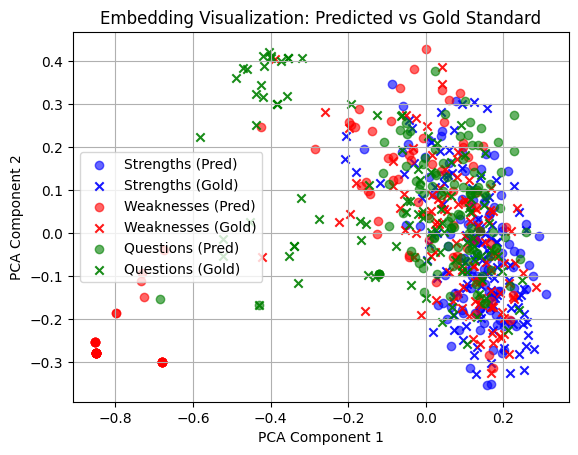

Llama-Summary-Zeroshot MSE_soundness = 2.69
Llama-Summary-Zeroshot MSE_presentation = 2.26
Llama-Summary-Zeroshot MSE_contribution = 3.49
Llama-Summary-Zeroshot MSE_rating = 19.02
Llama-Summary-Zeroshot MSE_confidence = 2.01
Llama-Summary-Zeroshot Strengths_BertScore = 0.8437802195549011 / 0.8620954751968384 / 0.8526933789253235
Llama-Summary-Zeroshot Weaknesses_BertScore = 0.7953332662582397 / 0.8511006236076355 / 0.8220327496528625
Llama-Summary-Zeroshot Questions_BertScore = 0.7938140034675598 / 0.8078411221504211 / 0.8001914024353027




In [490]:
numerical_scores = ["Soundness", "Presentation", "Contribution", "Rating", "Confidence"]
text_fields = ["Strengths", "Weaknesses", "Questions"]

results_list = []

for association in associations_valid:
    gold_standard, predictions = get_gold_and_predictions(association)

    gold_scores = []
    pred_scores = []

    gold_text = []
    pred_text = []
    for prediction in predictions:
        gold = list([item for item in gold_standard if item.keys() == prediction.keys()][0].values())[0]
        prediction = list(prediction.values())[0]
        gold_scores.append([gold[category] for category in numerical_scores])
        pred_scores.append([prediction[category] for category in numerical_scores])

        gold_text.append([gold[category] for category in text_fields])
        pred_text.append([prediction[category] for category in text_fields])
    gold_scores = np.array(gold_scores)
    pred_scores = np.array(pred_scores)

    gold_text = np.array(gold_text)
    pred_text = np.array(pred_text)

    mean_precision_strengths, mean_recall_strengths, mean_f1_strengths = calc_bertscore(gold_text[:,0], pred_text[:,0])
    mean_precision_weaknesses, mean_recall_weaknesses, mean_f1_weaknesses = calc_bertscore(gold_text[:,1], pred_text[:,1])
    mean_precision_questions, mean_recall_questions, mean_f1_questions = calc_bertscore(gold_text[:,2], pred_text[:,2])

    all_embeddings = np.vstack([
        model.encode(pred_text[:,0]), model.encode(gold_text[:,0]),
        model.encode(pred_text[:,1]), model.encode(gold_text[:,1]),
        model.encode(pred_text[:,2]), model.encode(gold_text[:,2]),
    ])
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)
    split_idx = len(pred_text[:,0])
    pred_str_2d = embeddings_2d[:split_idx]
    gold_str_2d = embeddings_2d[split_idx:2*split_idx]
    pred_weak_2d = embeddings_2d[2*split_idx:3*split_idx]
    gold_weak_2d = embeddings_2d[3*split_idx:4*split_idx]
    pred_ques_2d = embeddings_2d[4*split_idx:5*split_idx]
    gold_ques_2d = embeddings_2d[5*split_idx:]

    categories = [
    ("Strengths", pred_str_2d, gold_str_2d, 'blue'),
    ("Weaknesses", pred_weak_2d, gold_weak_2d, 'red'),
    ("Questions", pred_ques_2d, gold_ques_2d, 'green')
    ]

    for label, pred, gold, color in categories:
        plt.scatter(pred[:, 0], pred[:, 1], marker='o', label=f"{label} (Pred)", color=color, alpha=0.6)
        plt.scatter(gold[:, 0], gold[:, 1], marker='x', label=f"{label} (Gold)", color=color, alpha=0.9)
        
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Embedding Visualization: Predicted vs Gold Standard")
    plt.legend()
    plt.grid()
    plt.show()
    


    print(association[2] + ' MSE_soundness = ' + str(mean_squared_error(gold_scores[:,0], pred_scores[:,0])))
    print(association[2] + ' MSE_presentation = ' + str(mean_squared_error(gold_scores[:,1], pred_scores[:,1])))
    print(association[2] + ' MSE_contribution = ' + str(mean_squared_error(gold_scores[:,2], pred_scores[:,2])))
    print(association[2] + ' MSE_rating = ' + str(mean_squared_error(gold_scores[:,3], pred_scores[:,3])))
    print(association[2] + ' MSE_confidence = ' + str(mean_squared_error(gold_scores[:,4], pred_scores[:,4])))
    print(association[2] + ' Strengths_BertScore = ' + str(mean_precision_strengths) + ' / ' + str(mean_recall_strengths) + ' / ' + str(mean_f1_strengths))
    print(association[2] + ' Weaknesses_BertScore = ' + str(mean_precision_weaknesses) + ' / ' + str(mean_recall_weaknesses) + ' / ' + str(mean_f1_weaknesses))
    print(association[2] + ' Questions_BertScore = ' + str(mean_precision_questions) + ' / ' + str(mean_recall_questions) + ' / ' + str(mean_f1_questions))
    print('\n')

    results_list.append({
        "Model": association[2],
        "MSE_Soundness": mean_squared_error(gold_scores[:, 0], pred_scores[:, 0]),
        "MSE_Presentation": mean_squared_error(gold_scores[:, 1], pred_scores[:, 1]),
        "MSE_Contribution": mean_squared_error(gold_scores[:, 2], pred_scores[:, 2]),
        "MSE_Rating": mean_squared_error(gold_scores[:, 3], pred_scores[:, 3]),
        "MSE_Confidence": mean_squared_error(gold_scores[:, 4], pred_scores[:, 4]),
        "Strengths_Precision": mean_precision_strengths,
        "Strengths_Recall": mean_recall_strengths,
        "Strengths_F1": mean_f1_strengths,
        "Weaknesses_Precision": mean_precision_weaknesses,
        "Weaknesses_Recall": mean_recall_weaknesses,
        "Weaknesses_F1": mean_f1_weaknesses,
        "Questions_Precision": mean_precision_questions,
        "Questions_Recall": mean_recall_questions,
        "Questions_F1": mean_f1_questions
    })


In [466]:
get_gold_and_predictions(association)[1]

[{'B0OwtVEejJ': {'Soundness': 3,
   'Presentation': 3,
   'Contribution': 3,
   'Rating': 7,
   'Confidence': 4,
   'Strengths': 'The paper presents a novel approach by integrating weight-entanglement with gradient-based NAS methods, potentially enhancing the performance of NAS searches in weight-entangled spaces. This approach promises improved memory efficiency and enhanced performance, which are significant contributions to the NAS field.',
   'Weaknesses': 'The paper might not clearly articulate the limitations or potential downsides of integrating weight-entanglement with gradient-based NAS methods. Although it mentions comparative assessments, details on experimental setup and results might require additional clarity for validation.',
   'Questions': 'How does the proposed integration affect the computational overhead compared to traditional NAS methods without weight-entanglement? Are there specific scenarios where the proposed method might underperform compared to existing NAS 

In [482]:
json.loads(list(get_gold_and_predictions(association)[1][0].values())[0])

{'Soundness': 4,
 'Presentation': 3,
 'Contribution': 4,
 'Rating': 9,
 'Confidence': 5,
 'Strengths': 'The authors provide a clear and well-structured paper with a good hypothesis and a well-defined method. The experiments are comprehensive and the results are presented in a clear and concise manner.',
 'Weaknesses': 'The paper assumes some knowledge of NAS methods and weight-entanglement, which might make it difficult for non-experts to understand. The authors could provide more details about the implementation of TangleNAS.',
 'Questions': 'How does TangleNAS compare to other NAS methods in terms of computational complexity? Are there any potential drawbacks to using weight-entanglement in larger search spaces?'}

In [423]:
valid_statistics = pd.DataFrame(results_list)
valid_statistics

,Model,MSE_Soundness,MSE_Presentation,MSE_Contribution,MSE_Rating,MSE_Confidence,Strengths_Precision,Strengths_Recall,Strengths_F1,Weaknesses_Precision,Weaknesses_Recall,Weaknesses_F1,Questions_Precision,Questions_Recall,Questions_F1
0,GPT4o-Abstract-Fewshot,1.867347,1.336735,2.346939,9.438776,0.663265,0.862318,0.857756,0.859868,0.816474,0.851035,0.833190,0.832425,0.831350,0.831366
1,GPT4o-Abstract-Oneshot,2.050505,1.454545,2.313131,9.242424,0.676768,0.863736,0.858842,0.861105,0.817469,0.854356,0.835280,0.832658,0.833649,0.832621
2,GPT4o-Abstract-Zeroshot,1.949495,1.444444,2.808081,9.969697,0.646465,0.856266,0.868674,0.862227,0.809750,0.854894,0.831503,0.827611,0.839432,0.832914
3,GPT4o-Summary-Fewshot,2.110000,1.420000,2.470000,10.820000,0.670000,0.861705,0.856283,0.858823,0.818106,0.851855,0.834424,0.834399,0.830286,0.831812
4,GPT4o-Summary-Oneshot,2.220000,2.030000,2.560000,10.650000,0.590000,0.864991,0.857089,0.860864,0.818642,0.851966,0.834752,0.835280,0.832947,0.833593
5,GPT4o-Summary-Zeroshot,2.140000,1.280000,2.990000,11.050000,0.600000,0.858179,0.865927,0.861853,0.810177,0.852924,0.830785,0.828417,0.834683,0.831017
6,GPT4o-Full_Text-Oneshot,2.030612,2.081633,2.193878,9.704082,0.765306,0.866914,0.854971,0.860735,0.820729,0.849387,0.834622,0.836768,0.831285,0.833522
7,GPT4o-Full_Text-Zeroshot,1.590000,1.320000,2.290000,7.950000,0.730000,0.860082,0.862655,0.861179,0.813509,0.851950,0.832079,0.829791,0.835636,0.832144


In [427]:
test_statistics = pd.DataFrame(results_list)
test_statistics

,Model,MSE_Soundness,MSE_Presentation,MSE_Contribution,MSE_Rating,MSE_Confidence,Strengths_Precision,Strengths_Recall,Strengths_F1,Weaknesses_Precision,Weaknesses_Recall,Weaknesses_F1,Questions_Precision,Questions_Recall,Questions_F1
0,GPT4o-Abstract-Fewshot,1.650000,1.250000,1.940000,7.890000,0.750000,0.860234,0.861961,0.860921,0.814182,0.853888,0.833345,0.823364,0.835813,0.829108
1,GPT4o-Abstract-Oneshot,1.929293,1.636364,2.252525,8.272727,0.787879,0.863394,0.862709,0.862881,0.815332,0.857275,0.835570,0.823848,0.839606,0.831167
2,GPT4o-Abstract-Zeroshot,1.380000,1.130000,2.250000,6.860000,0.750000,0.854416,0.871549,0.862687,0.806594,0.856341,0.830521,0.817420,0.841680,0.828906
3,GPT4o-Summary-Fewshot,1.570000,1.230000,1.760000,7.360000,0.840000,0.863023,0.863702,0.863174,0.816968,0.853742,0.834741,0.825606,0.834429,0.829551
4,GPT4o-Summary-Oneshot,1.686869,1.595960,1.979798,7.626263,0.828283,0.865766,0.862679,0.864041,0.818265,0.855611,0.836327,0.827878,0.838837,0.832863
5,GPT4o-Summary-Zeroshot,1.700000,1.190000,2.380000,7.660000,0.860000,0.856333,0.869935,0.862881,0.808959,0.855903,0.831575,0.818014,0.840831,0.828824
6,GPT4o-Full_Text-Oneshot,1.670000,1.770000,1.900000,7.120000,0.730000,0.866141,0.862078,0.863938,0.818862,0.853543,0.835623,0.827078,0.836509,0.831339
7,GPT4o-Full_Text-Zeroshot,1.190000,0.970000,1.840000,6.110000,0.690000,0.858754,0.869577,0.863942,0.811025,0.856086,0.832732,0.817983,0.838740,0.827813


In [428]:
with pd.ExcelWriter('Analysis.xlsx', mode='w', engine='openpyxl') as writer:
    valid_statistics.to_excel(writer, sheet_name='Valid')
    test_statistics.to_excel(writer, sheet_name='Test')

In [386]:
confusion_matrix_gen(pred_scores, gold_scores)

(array([[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 4, 15, 10,  3],
        [ 5, 25, 35,  3]]),
 array([[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 9, 23, 30,  3],
        [ 0, 11, 22,  2]]),
 array([[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 4, 11,  2,  0],
        [ 4, 53, 24,  2]]),
 array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  5,  0,  2,  1,  0,  0,  0,  0],
        [ 2,  0,  8,  0, 10,  6,  0,  3,  0,  0],
        [ 1,  0, 16,  0, 22, 15,  0,  4,  0,  0],
        [ 0,  0,  1,  0,  2,  1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  3,  5],
        [ 1,  2, 27, 51]]))

In [135]:
def parse_review(text):
    text = text.replace('\nExplanation:\n', '',1)
    review_dict = {}
    
    # Split text into sections using double newlines as a separator
    sections = re.split(r"\n\n", text.strip())

    for section in sections:
        lines = section.split("\n")
        #lines = section
        
        # First part contains numerical ratings
        if ": " in lines[0]:
            for line in lines:
                if ": " in line:
                    key, value = line.split(": ", 1)
                    review_dict[key.strip()] = int(value) if value.isdigit() else value.strip()
        
        # Later parts contain explanations, strengths, weaknesses, questions
        else:
            key = lines[0].replace(":", "").strip()  # Remove colons and extra spaces
            review_dict[key] = "\n".join(lines[1:]).strip()  # Store the rest of the section

    return review_dict

In [136]:
import re

def parse_review1(text):
    # Define regex patterns for extracting different sections
    score_pattern = r"(\w+): (\d+)"
    section_pattern = r"(Strengths|Weaknesses|Questions):\n"

    # Initialize dictionary
    review_dict = {}

    # Extract numerical scores
    scores = re.findall(score_pattern, text)
    for key, value in scores:
        review_dict[key] = int(value)  # Convert scores to integers

    # Extract text sections
    sections = re.split(section_pattern, text)
    
    # Process sections
    for i in range(1, len(sections), 2):
        key = sections[i].strip()
        value = sections[i + 1].strip()
        review_dict[key] = value

    return review_dict


In [152]:
gold_standard = {item['paper_id']: parse_review1(item['response']) for item in gold_standard}
predictions = {item['paper_id']: parse_review1(item['response']) for item in predictions}


TypeError: string indices must be integers

In [215]:
with open('matched_papers_reviews_test.json', 'r') as f:
    papers_2025 = json.load(f)

In [216]:
def remove_citations(full_text):
    idx = full_text.find('\n\nREFERENCES')
    if idx == -1:
        idx = full_text.find('\n\nReferences')
    return full_text[:idx]

In [217]:
with open('instruction_finetuning_data.jsonl', 'r') as f:
    train_data = [json.loads(line) for line in f]
with open('instruction_finetuning_data_test.jsonl', 'r') as f:
    test_data = [json.loads(line) for line in f]

In [218]:
prompt_string = """
Categories (1–5):
- Soundness: The rigor of the methods for the stated problem
- Presentation: The clarity of writing and organization
- Contribution: The paper’s novelty or added value to the domain

Additionally:
- Rating (1–10): Overall recommendation for acceptance
- Confidence (1–5): How confident the reviewer is in their assessment

Please provide:
1) Soundness
2) Presentation
3) Contribution
4) Rating
5) Confidence
6) Explanation (strengths, weaknesses)
7) Questions
"""

In [219]:
json_txt = [{'paper_id': item['paper_id'], 
             'summary': item['prompt'].replace(prompt_string, ''), 
             'full text': remove_citations(papers_2025[item['paper_id']]['full_text']['value']), 
             'abstract': papers_2025[item['paper_id']]['abstract']['value'],
             'response': parse_review1(item['response'])} 
             for item in test_data]

In [220]:
with open('instruction_finetuning_test_data_reformatted.json', "w", encoding="utf-8") as json_file:
    json.dump(json_txt, json_file, indent=4)

In [82]:
predictions = {k: predictions[k] for k in ('aAcOaJYbUg', 'dgR6i4TSng', 'UatDdAlr2x')}
predictions

{'aAcOaJYbUg': {'Soundness': 3,
  'Presentation': 3,
  'Contribution': 4,
  'Rating': 6,
  'Confidence': 3,
  'Strengths': '1. Clear structure and presentation: The paper is well-organized, with a logical structure and smooth flow that improves readability and comprehension.\n2. Insightful motivation for OOD benchmarking: This dataset addresses the critical issue of data leakage in current benchmarks. This approach highlights the limitations of evaluating current models trained on web-scale data.\n3. Interesting distortion design: The authors designed six distinct distortion types that minimize overlap with common real-world corruptions, reducing the likelihood of data leakage. This approach improves the dataset’s utility as a truly challenging OOD benchmark.',
  'Weaknesses': "1. Limited novel insights in model ranking comparisons: Figure 4 shows minimal divergence in the ranking of model performance between ImageNet-C and LAION-C. Similarly, Figure 3 demonstrates a strong linear corr

In [83]:
#def evaluate_review(predictions, gold_standard):
results = {}
numerical_scores = ["Soundness", "Presentation", "Contribution", "Rating", "Confidence"]
text_fields = ["Strengths", "Weaknesses", "Questions"]

num_pred = []
num_gold = []
for paper_id, response in predictions.items():
    gold = gold_standard[paper_id]
    results[paper_id] = {}

    num_pred = num_pred + [[response[category] for category in numerical_scores]]
    num_gold = num_gold + [[gold[category] for category in numerical_scores]]

    results[paper_id]["MAE"] = mean_absolute_error(num_gold, num_pred)
    results[paper_id]["MSE"] = mean_squared_error(num_gold, num_pred)

    text_results = {}
    #for text in text_fields:
    P, R, F1 = score([response[text_fields[0]], response[text_fields[1]], response[text_fields[2]]], 
                     [gold[text_fields[0]], gold[text_fields[1]], gold[text_fields[2]]], lang="en", rescale_with_baseline=True)
    text_results[text_fields[0] + "_BERTScore"] = F1[0]
    text_results[text_fields[1] + "_BERTScore"] = F1[1]
    text_results[text_fields[2] + "_BERTScore"] = F1[2]

    embeddings = model.encode([response[text_fields[0]], gold[text_fields[0]], response[text_fields[1]], gold[text_fields[1]], response[text_fields[1]], gold[text_fields[2]]])
    text_results[text_fields[0] + "_Embedding"] = (embeddings[0], embeddings[1])
    text_results[text_fields[1] + "_Embedding"] = (embeddings[2], embeddings[3])
    text_results[text_fields[2] + "_Embedding"] = (embeddings[4], embeddings[5])

    results[paper_id]['Text Comparisons'] = text_results
    
matrices = confusion_matrix_gen(num_pred, num_gold)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [393]:
embeddings

array([[-0.0558849 , -0.05132903, -0.01642488, ..., -0.00406978,
        -0.05793568,  0.05125476],
       [-0.0558849 , -0.05132903, -0.01642488, ..., -0.00406978,
        -0.05793568,  0.05125476],
       [-0.07210085,  0.0220222 , -0.036696  , ...,  0.04036839,
        -0.12883787,  0.04521313],
       [-0.07210085,  0.0220222 , -0.036696  , ...,  0.04036839,
        -0.12883787,  0.04521313],
       [-0.07210085,  0.0220222 , -0.036696  , ...,  0.04036839,
        -0.12883787,  0.04521313],
       [-0.10862166, -0.04697384,  0.05918695, ..., -0.02227457,
        -0.15968442,  0.08138366]], dtype=float32)

In [350]:
[response[text_fields[0]], response[text_fields[1]], response[text_fields[2]]]

['* The paper is well-written, easy to follow, and provides sufficient analysis for its claims.\n* Discovers and Discusses two strategies which 1-layer transformers can use to perform the counting task (i.e., relation-based and inventory-based) and in doing so considers a range of possible hyperparameter selections that affect this strategic choice.\n* During its analysis further studies the role of BoS token showing that together with softmax in the counting task, can help models with smaller p and d sizes to still reach perfect accuracy.',
 '* Limited scope and applicability, specifically: (1) Only examines single-layer transformers, (2)Focuses on just one task (histogram counting)\n* No clear path to extending insights to more complicated settings more specifically multi-layer transformers\n* Lack of practical impact in the sense that it is hard to find a direct translation from this paper findings to real-world transformer design for real-world tasks',
 'Have you done any analysis 

In [84]:
model.encode([predictions['aAcOaJYbUg']['Strengths'], gold_standard['aAcOaJYbUg']['Strengths']]).shape

(2, 384)

In [8]:
score([predictions['aAcOaJYbUg']['Explanation']], [gold_standard['aAcOaJYbUg']['Explanation']], lang='en', device='mps')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([1.0000]), tensor([1.0000]), tensor([1.0000]))